In [1]:
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import time
import ftm_u_shape
import math
import librosa
import librosa.display
import soundfile as sf
import sys
sys.path.append("../src")
import ftm_ver2 as ftm2
import ftm 
from kymatio.numpy import Scattering1D
#from nnAudio.features import CQT

to match max time support for both descriptors:

1. if Q = 24
J >= 15, in order for the f0 in CQT to be smaller than 40Hz
2. if Q = 12
J >= 14, in order for the f0 in CQT to be smaller than 40Hz
3. if Q = 2
J >= 11


not that important to match max time support, CQT results in more bins because it uses hop size, time scattering doesn't... after feature computation if we do pooling to match dimension then the receptive field for each coefficient is equivalent. what matters more is the filter resolution? and making sure fmin is the same

In [2]:
#pick J such that lowest center frequency lower than 40hz
sr = 22050
j = np.log(40/(0.4*sr))/np.log(2)
print("minimum J",j) #j must greater than 8
J = 14
print("J taken to be",J)
f_min = 0.4*sr*2**(-J)
print("f0 in TS",f_min)
#pick Q such that high freq resolution
Q = 12
print("Q taken to be",Q)
#pick f0 such that cqt's max time support matches TS's max time support
f0 = sr/(2**J*(2**(1/Q)-1)) 
print("f0 in CQT to match T_max",f0) 
#take f0 the same, pick b such that max time support matches
b = 1/(np.log(1+sr/Q)/np.log(2))
print("bins per octave in CQT to match T_max",b)
max_T = sr/f0/(2**(1/Q)-1)
print("max time support in CQT",max_T)

minimum J -7.7846348455575205
J taken to be 14
f0 in TS 0.538330078125
Q taken to be 12
f0 in CQT to match T_max 22.632949223607294
bins per octave in CQT to match T_max 0.09221422855191415
max time support in CQT 16384.0


## compare CQT, HCQT, VQT, Time Scattering
1. select hyperparameters for each feature such that maximum receptive field is roughly the same
2. ensure lowest center frequency covers 40hz
3. ensure frequency resolution is high (dataset's fundamental frequency is sampled in 10 intervals within 5 octaves)

In [15]:
#drum parameters
x1 = 0.5
x2 = 0.5
h = 0.03
tau11 = 0.2
p = 0.03
D = 0.08
l0 = np.pi*3
alpha_side = 1.5
sr = 22050

w11 = 100*2*np.pi
m=50
y1 = ftm2.getsounds_dif_linear_normlized(m,m,x1,x2,h,tau11,w11,p,D,np.pi,alpha_side,sr)
display(ipd.Audio(y1,rate=sr))

Text(0.5, 1.0, 'CQT of a typical drum sound')

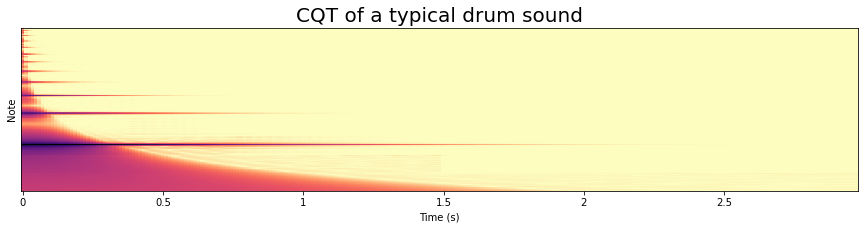

In [16]:
fig,ax = plt.subplots(1,1,figsize=(15,3))
C2 = np.abs(librosa.cqt(np.array(y1), sr=sr,bins_per_octave=b*2,fmin=fmin,n_bins=n_oct*b*2,hop_length=256))
librosa.display.specshow(np.log1p(C2/1e-3),sr=sr, x_axis='s',hop_length=256, 
                               y_axis='cqt_note',ax=ax,cmap="magma_r")
ax.set_title("CQT of a typical drum sound",fontsize=20)

In [4]:
delta_y = np.zeros(np.array(y1).shape)
delta_y[len(delta_y)//2]=1 

## CQT, VQT, pseudo-CQT, STFT comparison, spectrally

In [5]:
#time scattering hyperparameters
J = 9
Q = 24

#hyperparams of CQT, determine largest time support
b=Q #bins per octave
fmin=0.4*sr*2**(-J)#32.7 #lowest center frequency
fmin_ts = fmin
quality = 1/(2**(1/b)-1)
n_oct =J #does it have to match the mode number?
bw_min = fmin/Q
fmax_theo = fmin*2**(n_oct*b/b)#maximum center frequency
bw_max = fmax_theo/quality
T_max = sr/bw_min #should be 512 to match stft
print(b,bw_min,bw_max,fmin,fmin*2**(J),sr/2,T_max)

24 0.7177734375 258.44572719560006 17.2265625 8820.0 11025.0 30720.0


/home/han/miniconda3/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=512 is too small for input signal of length=256
  return f(*args, **kwargs)


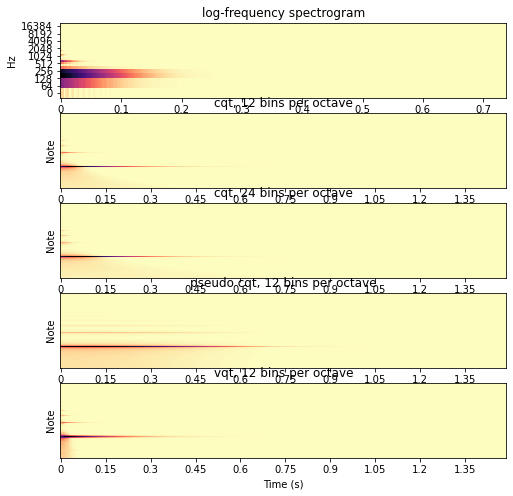

In [30]:
c = 1e-7
fig, ax = plt.subplots(5,1,figsize=(8,8))

##stft
#uniform time-frequency resolutioon
spec_stft,_,_,_ = plt.specgram(y1,Fs=sr,cmap="magma_r",NFFT=512, noverlap=256,scale="linear")#freq resolution=86hz
librosa.display.specshow(np.log1p(spec_stft/c),x_axis='s',sr=sr,hop_length=128,
                         y_axis='log',cmap="magma_r",ax=ax[0])
ax[0].set_title("log-frequency spectrogram")
#ax[0].set_ylim([0,1000])

##cqt 
#lower frequency has higher freq resolution/low temporal resolution and vice versa
#Q determined by bins per octave: 
#largest time support determined by fmin,bin/oct, frequency resolution too
y1 = np.array(y1)
C = np.abs(librosa.cqt(y1, sr=sr,bins_per_octave=b,fmin=fmin,n_bins=n_oct*b,hop_length=256))
librosa.display.specshow(np.log1p(C),sr=sr, x_axis='s',hop_length=256, 
                               y_axis='cqt_note',ax=ax[1],cmap="magma_r")
ax[1].set_title("cqt, 12 bins per octave")
#increase bins per octave, increase frequency resolution at low frequencies
C2 = np.abs(librosa.cqt(y1, sr=sr,bins_per_octave=b*2,fmin=fmin,n_bins=n_oct*b*2,hop_length=256))
librosa.display.specshow(np.log1p(C2),sr=sr, x_axis='s',hop_length=256, 
                               y_axis='cqt_note',ax=ax[2],cmap="magma_r")
ax[2].set_title("cqt, 24 bins per octave")
##pseudo cqt - use the same time support Tmax for all frequencies, so that frequency resolution is kept??
p_cqt = np.abs(librosa.pseudo_cqt(y1,sr=sr,bins_per_octave=b,fmin=fmin,n_bins=n_oct*b,hop_length=256))
librosa.display.specshow(np.log1p(p_cqt),sr=sr, x_axis='s',hop_length=256, 
                               y_axis='cqt_note',ax=ax[3],cmap="magma_r")
ax[3].set_title("pseudo cqt, 12 bins per octave")
#vqt - regulate max time support(usually smaller than the original f0 time support)
v_cqt = np.abs(librosa.vqt(y1,sr=sr,n_bins=n_oct*b,fmin=fmin,gamma=None,bins_per_octave=b,hop_length=256))
librosa.display.specshow(np.log1p(v_cqt),sr=sr, x_axis='s',hop_length=256, 
                               y_axis='cqt_note',ax=ax[4],cmap="magma_r")
ax[4].set_title("vqt, 12 bins per octave")
plt.show()

conclusions:
1. STFT divides frequency range linearly, CQT does it logarithmically. Number of filteres in STFT(N=256) MORE than CQT(=84). thus lots of adjacent bands in STFT might correspond to the same band in CQT.  
2. STFT energy's frequency resolution is not great, it has a lot of freq bins but no distinction between adjacent ones in low frequency (bandwidth too wide for low freq?)
3. pseudo cqt looks like it has uniform temporal support for all frequencies (the shadow is square), cqt has larger support for lower frequencies (shadow is triangular). vqt limit the time support for low frequencies, but the frequential energy captured has a larger band.

## comparison dimensionality
CQT, HCQT, VQT, Time scattering (second order)

In [31]:
spec_stft.shape,C.shape,C2.shape,p_cqt.shape,v_cqt.shape

((257, 255), (216, 257), (432, 257), (216, 257), (216, 257))

In [28]:
2**16/128

512.0

In [43]:
def get_hcqt_params():
    bins_per_octave=Q
    n_octaves = J-2
    harmonics = [0.5,1, 2, 3,4,5]
    sr = 44100#22050
    fmin = fmin_ts #32.7
    print(fmin_ts*2**(n_octaves))
    hop_length = 256#128
    return bins_per_octave, n_octaves, harmonics, sr, fmin, hop_length

def compute_hcqt(y,fs):
    bins_per_octave, n_octaves, harmonics, sr, f_min, hop_length = get_hcqt_params()
    cqt_list = []
    shapes = []
    for h in harmonics:
        cqt = librosa.cqt(
            y, sr=fs, hop_length=hop_length, fmin=f_min*float(h),
            n_bins=bins_per_octave*n_octaves,
            bins_per_octave=bins_per_octave
        )
        cqt_list.append(cqt)
        shapes.append(cqt.shape)
    
    shapes_equal = [s == shapes[0] for s in shapes]
    if not all(shapes_equal):
        min_time = np.min([s[1] for s in shapes])
        new_cqt_list = []
        for i, cqt in enumerate(cqt_list):
            new_cqt_list.append(cqt[:, :min_time])
            cqt_list.pop(i)
        cqt_list = new_cqt_list

    log_hcqt = 20.0*np.log10(np.abs(np.array(cqt_list)) + 0.0001)
    log_hcqt = log_hcqt - np.min(log_hcqt)
    log_hcqt = log_hcqt / np.max(log_hcqt)
    return log_hcqt

In [44]:
hcqt = compute_hcqt(y1,sr)

4410.0


In [45]:
hcqt.shape 

(6, 168, 257)

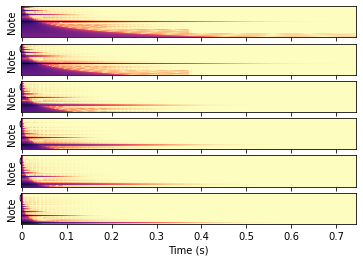

In [46]:
fig,ax = plt.subplots(6,1)
librosa.display.specshow(np.log1p(hcqt[0,:,:]),sr=sr, x_axis='s',hop_length=128, 
                               y_axis='cqt_note',ax=ax[0],cmap="magma_r")
librosa.display.specshow(np.log1p(hcqt[1,:,:]),sr=sr, x_axis='s',hop_length=128, 
                               y_axis='cqt_note',ax=ax[1],cmap="magma_r")
librosa.display.specshow(np.log1p(hcqt[2,:,:]),sr=sr, x_axis='s',hop_length=128, 
                               y_axis='cqt_note',ax=ax[2],cmap="magma_r")
librosa.display.specshow(np.log1p(hcqt[3,:,:]),sr=sr, x_axis='s',hop_length=128, 
                               y_axis='cqt_note',ax=ax[3],cmap="magma_r")
librosa.display.specshow(np.log1p(hcqt[4,:,:]),sr=sr, x_axis='s',hop_length=128, 
                               y_axis='cqt_note',ax=ax[4],cmap="magma_r")
librosa.display.specshow(np.log1p(hcqt[5,:,:]),sr=sr, x_axis='s',hop_length=128, 
                               y_axis='cqt_note',ax=ax[5],cmap="magma_r")
plt.show()

match TS and CQT in terms of J and Q
1. #octaves in filterbank, J 
2. #bins per octave in filterbank, Q
3. time support?


In [53]:
j = 12
q = 16
N = len(y1)
sr = 44100
y1 = np.array(y1)
timesc = Scattering1D(
        J = j, #scale, how big the biggest time support (for the lowest freqeuncy), where center frequencies are?
        shape = (N, ),
        Q = q,
        T = 2**j, 
        max_order=1,
        max_pad_factor=1,
        )
timesc_order2 = Scattering1D(
        J = j, #scale, how big the biggest time support (for the lowest freqeuncy), where center frequencies are?
        shape = (N, ),
        Q = q,
        T = None, 
        max_order=2,
        max_pad_factor=1,
        )
timesc_over = Scattering1D(
        J = j, #scale, how big the biggest time support (for the lowest freqeuncy), where center frequencies are?
        shape = (N, ),
        Q = q,
        T = None, 
        max_order=1,
        max_pad_factor=1,
        oversampling=1,
        )

Sy = timesc(y1)
Sdel = timesc(delta_y)
Sdel2 = timesc2(delta_y)
Sdel3 = timesc3(delta_y)

In [11]:
fmin_ts = 0.4*sr*2**(-j)
print(fmin_ts)

4.306640625


In [12]:
Sdel = timesc(delta_y)
CQT_del = librosa.cqt(delta_y,sr=sr,n_bins=q*j,fmin=fmin_ts,hop_length=2**j,bins_per_octave=q)
print(CQT_del.shape,Sdel.shape)

(192, 17) (161, 16)


/home/han/miniconda3/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=128 is too small for input signal of length=64
  return f(*args, **kwargs)
/home/han/miniconda3/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=128 is too small for input signal of length=32
  return f(*args, **kwargs)


(192, 17) (161, 16) (129, 64)


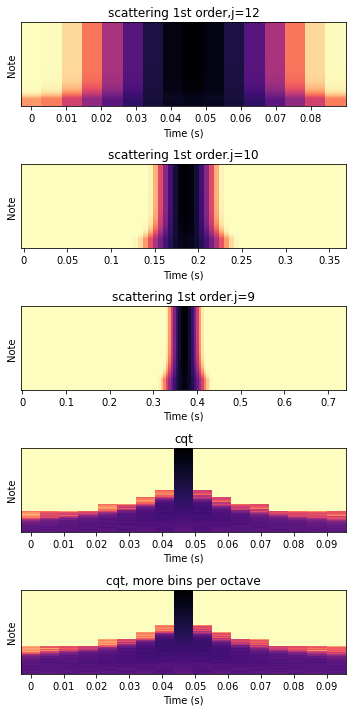

In [28]:
print(CQT_del.shape,Sdel.shape,Sdel2.shape)
c=1e-7
fig,ax = plt.subplots(5,1,figsize=(5,10))
librosa.display.specshow(np.log1p(Sdel[-1:0:-1,:]/c),sr=sr, x_axis='s',hop_length=256, 
                               y_axis='cqt_note',ax=ax[0],cmap="magma_r")
ax[0].set_title("scattering 1st order,j=12")

librosa.display.specshow(np.log1p(Sdel2[-1:0:-1,:]/c),sr=sr, x_axis='s',hop_length=256, 
                               y_axis='cqt_note',ax=ax[1],cmap="magma_r")
ax[1].set_title("scattering 1st order.j=10")


librosa.display.specshow(np.log1p(Sdel3[-1:0:-1,:]/c),sr=sr, x_axis='s',hop_length=256, 
                               y_axis='cqt_note',ax=ax[2],cmap="magma_r")
ax[2].set_title("scattering 1st order.j=9")


CQT_del = librosa.cqt(delta_y,sr=sr,n_bins=q*j,fmin=fmin_ts,hop_length=2**j,bins_per_octave=q)
#increase bins per octave, increase frequency resolution at low frequencies
librosa.display.specshow(np.log1p(CQT_del/c),sr=sr, x_axis='s',hop_length=256, 
                               y_axis='cqt_note',ax=ax[3],cmap="magma_r")
ax[3].set_title("cqt")
CQT_del2 = librosa.cqt(delta_y,sr=sr,n_bins=q*j*2,fmin=fmin_ts,hop_length=2**j,bins_per_octave=q*2)
#increase bins per octave, increase frequency resolution at low frequencies
librosa.display.specshow(np.log1p(CQT_del2/c),sr=sr, x_axis='s',hop_length=256, 
                               y_axis='cqt_note',ax=ax[4],cmap="magma_r")
ax[4].set_title("cqt, more bins per octave")
plt.tight_layout()

#plt.subplots_adjust(left=0.1,
#                    bottom=0.01, 
#                    right=0.9, 
#                    top=0.9, 
#                    wspace=0.4, 
#                    hspace=0.4)

In [16]:
fmin_ts = 0.4*sr*2**(-j)
fmin_cqt = sr/(2**j*(2**(1/q)-1))  # if take b=q and time support the same
print(fmin_cqt*2**(j-5-1/q))
print(fmin_ts,fmin_cqt,2**j,q/fmin_ts,sr/fmin_cqt/(2**(1/q)-1))
cqt = librosa.cqt(y1,sr=sr,n_bins=q*(j-5),fmin=fmin,hop_length=256,bins_per_octave=q) #can't take as many octaves
#cqt_nn = CQT(sr=sr,n_bins=J*Q,fmin=fmin_ts,hop_length=256,bins_per_octave=Q)
print(cqt.shape,Sy.shape)

29807.641201118215
4.306640625 243.18232986196045 4096 3.7151927437641725 4096.0


NameError: name 'fmin' is not defined

In [31]:
5*fmin*2**(j-2-1/b),22050/2

(10557.576169701775, 11025.0)

In [15]:
y1,sr = sf.read("/home/han/data/drum_data/val/22442_sound.wav")
j = 14
q = 32
N = len(y1)
y1 = np.array(y1)
              
def get_hcqt_params():
    bins_per_octave=q
    n_octaves = j-2
    harmonics = [0.5,1, 2, 3,4,5]
    sr = 22050
    fmin = 0.4*sr*2**(-j)
    hop_length = 256#128
    return bins_per_octave, n_octaves, harmonics, sr, fmin, hop_length

def compute_hcqt(y,fs):
    bins_per_octave, n_octaves, harmonics, sr, f_min, hop_length = get_hcqt_params()
    cqt_list = []
    shapes = []
    for h in harmonics:
        #print(h)
        cqt = librosa.cqt(
            y, sr=fs, hop_length=hop_length, fmin=f_min*float(h),
            n_bins=bins_per_octave*n_octaves,
            bins_per_octave=bins_per_octave
        )
        cqt_list.append(cqt)
        shapes.append(cqt.shape)
    
    shapes_equal = [s == shapes[0] for s in shapes]
    if not all(shapes_equal):
        min_time = np.min([s[1] for s in shapes])
        new_cqt_list = []
        for i, cqt in enumerate(cqt_list):
            new_cqt_list.append(cqt[:, :min_time])
            cqt_list.pop(i)
        cqt_list = new_cqt_list

    log_hcqt = 20.0*np.log10(np.abs(np.array(cqt_list)) + 0.0001)
    log_hcqt = log_hcqt - np.min(log_hcqt)
    log_hcqt = log_hcqt / np.max(log_hcqt)
    return log_hcqt
              
              
timesc = Scattering1D(
        J = j, #scale, how big the biggest time support (for the lowest freqeuncy), where center frequencies are?
        shape = (N, ),
        Q = q,
        T = 2**11, 
        max_order=1,
        max_pad_factor=1,
        )
timesc_order2 = Scattering1D(
        J = j, #scale, how big the biggest time support (for the lowest freqeuncy), where center frequencies are?
        shape = (N, ),
        Q = q,
        T = 2**11, 
        max_order=2,
        max_pad_factor=1,
        )
timesc_over = Scattering1D(
        J = j, #scale, how big the biggest time support (for the lowest freqeuncy), where center frequencies are?
        shape = (N, ),
        Q = q,
        T = 2**11, 
        max_order=1,
        max_pad_factor=1,
        oversampling=1,
        )

n_oct = j
b = q
fmin = 0.4*sr*2**(-j)
cqt = librosa.cqt(y1,sr=sr,n_bins=n_oct*b,fmin=fmin,hop_length=256,bins_per_octave=b) 
v_cqt = np.abs(librosa.vqt(y1,sr=sr,n_bins=n_oct*b,fmin=fmin,gamma=None,bins_per_octave=b,hop_length=256))
sc = timesc(y1) #after 2**j averaging window
sc_o2 = timesc_order2(y1) #order 2
sc_over = timesc_over(y1)
hcqt = compute_hcqt(y1,sr)

/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1024
  return f(*args, **kwargs)
/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=512
  return f(*args, **kwargs)
/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=16384 is too small for input signal of length=256
  return f(*args, **kwargs)


In [16]:
cqt.shape,v_cqt.shape,sc.shape,hcqt.shape,sc_o2.shape,sc_over.shape

((448, 257), (448, 257), (353, 32), (6, 384, 257), (2819, 32), (353, 64))

In [11]:
test_sc = Scattering1D(
        J = j, #scale, how big the biggest time support (for the lowest freqeuncy), where center frequencies are?
        shape = (N, ),
        Q = q,
        T = 2**11, 
        max_order=1,
        max_pad_factor=1,
        out_type = "list",
        )
Sy = test_sc(y1)


In [12]:
print(Sy[0]['coef'].shape,Sy[1]['j'],Sy[1]['coef'].shape,len(Sy))
for i in Sy:
    print(i['j'],i['n'],i['coef'].shape)


(32,) (0,) (32,) 161
() () (32,)
(0,) (0,) (32,)
(0,) (1,) (32,)
(0,) (2,) (32,)
(0,) (3,) (32,)
(0,) (4,) (32,)
(0,) (5,) (32,)
(0,) (6,) (32,)
(0,) (7,) (32,)
(0,) (8,) (32,)
(0,) (9,) (32,)
(0,) (10,) (32,)
(0,) (11,) (32,)
(0,) (12,) (32,)
(0,) (13,) (32,)
(0,) (14,) (32,)
(0,) (15,) (32,)
(0,) (16,) (32,)
(0,) (17,) (32,)
(1,) (18,) (32,)
(1,) (19,) (32,)
(1,) (20,) (32,)
(1,) (21,) (32,)
(1,) (22,) (32,)
(1,) (23,) (32,)
(1,) (24,) (32,)
(1,) (25,) (32,)
(1,) (26,) (32,)
(1,) (27,) (32,)
(1,) (28,) (32,)
(1,) (29,) (32,)
(1,) (30,) (32,)
(1,) (31,) (32,)
(1,) (32,) (32,)
(1,) (33,) (32,)
(2,) (34,) (32,)
(2,) (35,) (32,)
(2,) (36,) (32,)
(2,) (37,) (32,)
(2,) (38,) (32,)
(2,) (39,) (32,)
(2,) (40,) (32,)
(2,) (41,) (32,)
(2,) (42,) (32,)
(2,) (43,) (32,)
(2,) (44,) (32,)
(2,) (45,) (32,)
(2,) (46,) (32,)
(2,) (47,) (32,)
(2,) (48,) (32,)
(2,) (49,) (32,)
(3,) (50,) (32,)
(3,) (51,) (32,)
(3,) (52,) (32,)
(3,) (53,) (32,)
(3,) (54,) (32,)
(3,) (55,) (32,)
(3,) (56,) (32,)
(3,) (57

In [18]:
257/16,j*q,(j-2)*q,161/4,38*4/16

(16.0625, 192, 160, 40.25, 9.5)

In [6]:

def get_hcqt_params():
    bins_per_octave=q
    n_octaves = j-2
    harmonics = [0.5,1, 2, 3,4,5]
    sr = 22050
    fmin = 0.4*sr*2**(-j)
    hop_length = 256#128
    return bins_per_octave, n_octaves, harmonics, sr, fmin, hop_length

def compute_hcqt(y,fs):
    bins_per_octave, n_octaves, harmonics, sr, f_min, hop_length = get_hcqt_params()
    cqt_list = []
    shapes = []
    for h in harmonics:
        #print(h)
        cqt = librosa.cqt(
            y, sr=fs, hop_length=hop_length, fmin=f_min*float(h),
            n_bins=bins_per_octave*n_octaves,
            bins_per_octave=bins_per_octave
        )
        cqt_list.append(cqt)
        shapes.append(cqt.shape)
    
    shapes_equal = [s == shapes[0] for s in shapes]
    if not all(shapes_equal):
        min_time = np.min([s[1] for s in shapes])
        new_cqt_list = []
        for i, cqt in enumerate(cqt_list):
            new_cqt_list.append(cqt[:, :min_time])
            cqt_list.pop(i)
        cqt_list = new_cqt_list

    log_hcqt = 20.0*np.log10(np.abs(np.array(cqt_list)) + 0.0001)
    log_hcqt = log_hcqt - np.min(log_hcqt)
    log_hcqt = log_hcqt / np.max(log_hcqt)
    return log_hcqt